# Matrix Factorization
This notebook explores a matrix factorization approach for the recommender system

In [2]:
import pandas as pd

artists = pd.read_csv('../dataset/artists.dat', sep='\t')
tags = pd.read_csv('../dataset/tags.dat', sep='\t', encoding='ISO-8859-1')
user_artists = pd.read_csv('../dataset/user_artists.dat', sep='\t')
user_tags = pd.read_csv('../dataset/user_taggedartists.dat', sep='\t')

print(f"Original length: {len(user_artists)}")
user_tags.head()

Original length: 92834


,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In this notebook, we will build a baseline model that recommends the most popular items to all users. We will then build a matrix factorization model using the Alternating Least Squares (ALS) algorithm.

As a convention, we will deal with top 10 recommendations for each user.

In [3]:
class Baseline():
    """
    A model that always recommends the most popular artists.
    """
    def __init__(self, top):
        self.top = top

    def fit(self, user_artists):
        self.popular_artists = user_artists.groupby('artistID').sum().sort_values('weight', ascending=False).index[:self.top]

    def recommend(self, user_id):
        return self.popular_artists[:self.top]

We should also build functions to evaluate the performance of the model. We will use Precision@k, Recall@k and Coverage as the evaluation metrics.

In [4]:
base = Baseline(10)
base.fit(user_artists)
base.recommend(2)

Index([289, 72, 89, 292, 498, 67, 288, 701, 227, 300], dtype='int64', name='artistID')

In [5]:
from sklearn.metrics import roc_auc_score

def is_relevant(recommended, user_id, user_artists):
    """
    Returns a boolean array indicating whether each recommended artist is relevant to the user.
    An artist is relevant if the user has listened to it at least k times.
    """

    user_artists = user_artists[user_artists.userID == user_id]
    
    relevant = []
    for artist_id in recommended:
        relevant.append(artist_id in user_artists.artistID.values)
    return relevant

def precision(recommended, user_id, user_artists):
    """
    Returns the precision of the recommendations.
    Precision is the proportion of recommended artists that are relevant.
    """

    relevant = is_relevant(recommended, user_id, user_artists)
    return sum(relevant) / len(recommended)

def recall(recommended, user_id, user_artists):
    """
    Returns the recall of the recommendations.
    Recall is the proportion of relevant artists that are recommended.
    """

    relevant = is_relevant(recommended, user_id, user_artists)
    return sum(relevant) / len(user_artists[user_artists.userID == user_id])

def f1_score(recommended, user_id, user_artists):
    """
    Returns the F1 score of the recommendations.
    The F1 score is the harmonic mean of precision and recall.
    """

    prec = precision(recommended, user_id, user_artists)
    rec = recall(recommended, user_id, user_artists)

    if prec + rec == 0:
        return 0
    
    return 2 * prec * rec / (prec + rec)

def coverage(recommended, user_artists):
    """
    Returns the coverage of the recommendations.
    Coverage is the proportion of artists that are recommended.
    """

    return len(recommended) / len(user_artists.artistID.unique())

def auc(recommended, user_id, user_artists):
    """
    Returns the AUC (Area Under the Curve) of the recommendations for a specific user.
    AUC measures the ranking quality of recommendations.
    """
    # Get all artists the user has interacted with
    user_artists = user_artists[user_artists.userID == user_id]
    relevant_artists = set(user_artists.artistID.values)

    # Create binary labels: 1 if relevant, 0 if not
    y_true = [1 if artist_id in relevant_artists else 0 for artist_id in recommended]
    y_scores = list(range(len(recommended), 0, -1))  # Higher rank means higher score

    # If there are no relevant artists, return NaN to ignore in the average
    if sum(y_true) == 0:
        return float('nan')

    return roc_auc_score(y_true, y_scores)

def evaluate(model, user_artists, user_ids):
    """
    Evaluates a model on a set of users.
    Returns a dictionary containing the average precision, recall, F1 score, coverage, and AUC.
    """

    model.fit(user_artists)

    precisions = []
    recalls = []
    f1_scores = []
    aucs = []

    recommendations = set()

    for user_id in user_ids:
        recommended = model.recommend(user_id)
        precisions.append(precision(recommended, user_id, user_artists))
        recalls.append(recall(recommended, user_id, user_artists))
        f1_scores.append(f1_score(recommended, user_id, user_artists))
        aucs.append(auc(recommended, user_id, user_artists))
        
        recommendations.update(recommended)

    # Filter out NaN values from AUC
    aucs = [a for a in aucs if not pd.isna(a)]

    return {
        'precision': sum(precisions) / len(precisions),
        'recall': sum(recalls) / len(recalls),
        'f1_score': sum(f1_scores) / len(f1_scores),
        'coverage': len(recommendations) / len(user_artists.artistID.unique()),
        'auc': sum(aucs) / len(aucs) if aucs else float('nan')  # Avoid division by zero
    }
    

In [6]:
evaluate(base, user_artists, user_artists.userID.unique())

{'precision': 0.2328752642706131,
 'recall': 0.048249036830513736,
 'f1_score': 0.07875021852213392,
 'coverage': 0.0005671506352087115,
 'auc': 0.4842685660715725}

Our baseline model gets a Precision@10 of 0.23, Recall@10 of 0.04 and F1@10 of 0.07.

# Matrix factorization
Now, we build a matrix factorization model using LightFM.

In [94]:
print(user_artists["artistID"].unique().size)

17632


In [95]:
# Start by generating a sparse matrix of user-artist interactions.
from scipy.sparse import coo_matrix

user_artist_matrix = coo_matrix((user_artists.weight, (user_artists.userID, user_artists.artistID)))
user_artist_matrix.shape

(2101, 18746)

In [96]:
from sklearn.preprocessing import normalize
user_artist_matrix = normalize(user_artist_matrix, axis=1)

In [97]:
def get_sparsity(matrix):
    """
    Returns the sparsity of a matrix.
    Sparsity is the proportion of zero values in the matrix.
    """

    return 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])

print(f"Sparsity: {get_sparsity(user_artist_matrix)}")

Sparsity: 0.9976429304442317


In [98]:
# %pip install git+https://github.com/daviddavo/lightfm

In [99]:
from lightfm import cross_validation
train, test = cross_validation.random_train_test_split(user_artist_matrix, test_percentage=0.2)

In [100]:
# Count the number of non-empty entries in the training and test sets.
train.nnz, test.nnz

(74267, 18567)

In [101]:
from lightfm import LightFM

model = LightFM(loss='warp')
model.fit(train, epochs=10)

In [102]:
from lightfm.evaluation import precision_at_k, recall_at_k

train_precision = precision_at_k(model, train, k=10).mean()
print(f"Train precision: {train_precision}")

Train precision: 0.38111114501953125


In [41]:
from lightfm.evaluation import precision_at_k, recall_at_k

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_recall = recall_at_k(model, train, k=10).mean()
test_recall = recall_at_k(model, test, k=10, train_interactions=train).mean()

In [42]:
print(f"Train precision: {train_precision}")
print(f"Test precision: {test_precision}")
print(f"Train recall: {train_recall}")
print(f"Test recall: {test_recall}")

Train precision: 0.3635449707508087
Test precision: 0.12004254013299942
Train recall: 0.09331063419106211
Test recall: 0.12347351671082296


Obtenemos una precision@k de 0.38 (en testing), considerablemente mejor que el modelo baseline

In [43]:
import time

def partial_fit_with_test_evaluation(model, train, test, epochs, threads=8, k=10):
    """
    Fits a model incrementally on a training dataset and evaluates precision@k on the test set.
    """
    train_precisions = []
    test_precisions = []

    times = []

    for epoch in range(epochs):
        start_time = time.time()
        
        # Fit the model incrementally on the training set
        model.fit_partial(train, epochs=1, num_threads=threads)

        # Compute precision@k for the training set
        train_precision = precision_at_k(model, train, k=k).mean()
        train_precisions.append(train_precision)

        # Compute precision@k for the test set
        test_precision = precision_at_k(model, test, k=k).mean()
        test_precisions.append(test_precision)

        end_time = time.time()
        epoch_time = end_time - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch + 1}/{epochs} - Train Precision@{k}: {train_precision:.4f}, Test Precision@{k}: {test_precision:.4f}, Time: {epoch_time:.2f} seconds")

    return train_precisions, test_precisions


In [45]:
model = LightFM(loss='bpr')
train_precision, test_precision = partial_fit_with_test_evaluation(model, train,test, 1)

Epoch 1/10 - Train Precision@10: 0.1089, Test Precision@10: 0.0258
Epoch 2/10 - Train Precision@10: 0.1589, Test Precision@10: 0.0373
Epoch 3/10 - Train Precision@10: 0.2306, Test Precision@10: 0.0548
Epoch 4/10 - Train Precision@10: 0.2843, Test Precision@10: 0.0646
Epoch 5/10 - Train Precision@10: 0.2860, Test Precision@10: 0.0651
Epoch 6/10 - Train Precision@10: 0.2912, Test Precision@10: 0.0669
Epoch 7/10 - Train Precision@10: 0.3054, Test Precision@10: 0.0681
Epoch 8/10 - Train Precision@10: 0.3237, Test Precision@10: 0.0714
Epoch 9/10 - Train Precision@10: 0.3347, Test Precision@10: 0.0725
Epoch 10/10 - Train Precision@10: 0.3485, Test Precision@10: 0.0753


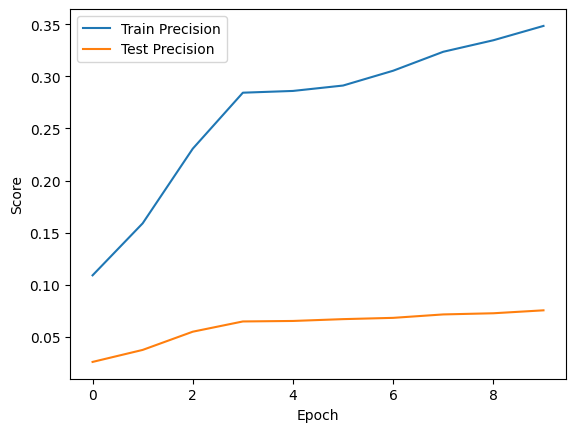

In [46]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(10), y=train_precision, label='Train Precision')
sns.lineplot(x=range(10), y=test_precision, label='Test Precision')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


# Using tags to build a hybrid model
We will now build a hybrid model that combines the matrix factorization model with the tags of the items. We will use the tags to build item features and use them in the matrix factorization model.

In [58]:
# First, reorder the dataset by building a mapping from user ids to their index
user_ids = user_artists.userID.unique()
user_id_to_index = {id: i for i, id in enumerate(user_ids)}

# Then, build a mapping from artist ids to their index
artist_ids = artists.id.unique()
artist_id_to_index = {id: i for i, id in enumerate(artist_ids)}

tag_ids = tags.tagID.unique()
tag_id_to_index = {id: i for i, id in enumerate(tag_ids)}

print(user_ids.shape, artist_ids.shape)


(1892,) (17632,)


In [60]:
updated_user_artists = user_artists.copy()
updated_user_artists['userID'] = user_artists['userID'].map(user_id_to_index)
updated_user_artists['artistID'] = user_artists['artistID'].map(artist_id_to_index)

updated_artists = artists.copy()
updated_artists['id'] = artists['id'].map(artist_id_to_index)

updated_user_tags = user_tags.copy()
updated_user_tags['userID'] = user_tags['userID'].map(user_id_to_index)

updated_user_tags['artistID'] = user_tags['artistID'].map(artist_id_to_index).fillna(-1).astype(int)
updated_user_tags = updated_user_tags[updated_user_tags['artistID'] != -1]

updated_user_tags['tagID'] = user_tags['tagID'].map(tag_id_to_index)

updated_tags = tags.copy()
updated_tags['tagID'] = tags['tagID'].map(tag_id_to_index)

print(updated_user_artists.shape)
print(updated_user_tags.shape)


(92834, 3)
(184941, 6)


In [81]:
# Build a sparse matrix of item features
from scipy.sparse import coo_matrix

artist_tag_counts = updated_user_tags.groupby(['artistID','tagID']).size().reset_index(name='count')
artist_tag_counts.head()

# Drop all rows that do not match any artist
artist_tag_counts = artist_tag_counts[artist_tag_counts['artistID'].isin(artist_id_to_index.keys())]
top_n = 5
# Now, generate a matrix of artist-tag interactions, considering only the top n tags for each artist
artist_tag_matrix = coo_matrix((artist_tag_counts['count'], (artist_tag_counts['artistID'], artist_tag_counts['tagID'])))

print(artist_tag_counts['artistID'].unique().shape)



(11530,)


In [83]:
print(updated_artists.shape)
print(updated_user_artists['artistID'].unique().shape)
print(updated_user_tags['artistID'].isin(artist_id_to_index.keys()).unique().shape)

(17632, 4)
(17632,)
(2,)


In [69]:
# Build new sparse matrix
from scipy.sparse import coo_matrix

user_artist_matrix = coo_matrix((updated_user_artists.weight, (updated_user_artists.userID, updated_user_artists.artistID)))

In [71]:
from lightfm import cross_validation

train, test = cross_validation.random_train_test_split(user_artist_matrix, test_percentage=0.2)

print(train.shape)

(1892, 17632)


In [89]:
import pandas as pd
from scipy.sparse import csr_matrix, vstack

# Step 1: Count occurrences of each tag for each artist
artist_tag_counts = user_tags.groupby(['artistID', 'tagID']).size().reset_index(name='count')

# Step 2: Select the top N tags for each artist (e.g., top 3)
top_n = 5
artist_top_tags = artist_tag_counts.sort_values(['artistID', 'count'], ascending=[True, False]) \
                                   .groupby('artistID').head(top_n)

# Step 3: Build a mapping from tagID to column index
unique_tags = artist_top_tags['tagID'].unique()
tag_mapping = {tag_id: idx for idx, tag_id in enumerate(unique_tags)}

# Step 4: Map artistID and tagID to indices
# Get all artists from the train matrix
all_artists = sorted(user_artists['artistID'].unique())  # Sorted list of all artistIDs
artist_mapping = {artist_id: idx for idx, artist_id in enumerate(all_artists)}  # Map all artists

# Map artistID to indices for existing data
artist_top_tags['artist_idx'] = artist_top_tags['artistID'].map(artist_mapping)
artist_top_tags['tag_idx'] = artist_top_tags['tagID'].map(tag_mapping)

# Step 5: Create the initial sparse matrix
rows = artist_top_tags['artist_idx']
cols = artist_top_tags['tag_idx']
data = artist_top_tags['count']

print(rows.size)
print(cols.size)




46950
46950


In [72]:
from lightfm import LightFM
mode = LightFM(loss='bpr', no_components=30)
mode.fit(train, item_features=artist_tag_matrix, epochs=10, num_threads=16)

Exception: Number of item feature rows does not equal the number of items